# TP facultatif : Préparation du jeu de données brut

Quand on se lance avec enthousiasme dans un nouveau projet de machine-learning, on pense avant tout au choix du modèle que l'on va utiliser. Cependant, et même s'il ne s'agit pas de l'étape la plus agréable du travail, un préalable indispensable est de réunir les données brutes et de les mettre en forme pour qu'elles puissent être ingérées par le modèle.

L'objectif de ce TP est de comprendre comment, à partir de différentes sources de données, on construit nos jeux de données "propres" pour ensuite construire le meilleur modèle d'apprentissage possible pour la prévision de consommation nationale.

Nos fichiers d'entrée bruts sont les suivants :
> * YconsoT0.csv
> * joursFeries.csv
> * StationsMeteoRTE.csv  # Les coordonnées géographiques et les poids associés aux stations météos
> * meteoX_T0_T24.zip
> * eCO2mix_RTE_tempo_2017-2018.xls  # le sinformations sur les jours TEMPO

Et les fichiers que l'on va créer sont :
> * Xinput.csv  # Les entrées pour le modèle d'apprentissage
> * Yconso.csv  # les sorties pour le modèle d'apprentissage

## Environnement

Chargement des librairies python, et quelques éléments de configuration.

In [131]:
# Exécutez la cellule ci-dessous (par exemple avec shift-entrée)
# Si vous exécuter ce notebook depuis votre PC, il faudra peut-etre installer certaines librairies avec 
# 'pip3 install ma_librairie'
import os  # accès aux commandes système
import datetime  # structure de données pour gérer des objets calendaires
import pandas as pd  # gérer des tables de données en python
import numpy as np  # librairie d'opérations mathématiques
import zipfile # manipulation de fichiers zip
import urllib3 # téléchargement de fichier
import pytz

import plotly
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot, iplot_mpl
import matplotlib.pyplot as plt  # tracer des visualisations
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

%autosave 0

data_folder = os.path.join(os.getcwd(),"data")

print("")
print("Mon repertoire de data est : {}".format(data_folder))
print("")
print("Fichiers contenus dans ce répertoire :")
for file in os.listdir(data_folder):
    print(" - " + file)

Autosave disabled

Mon repertoire de data est : D:\Users\montuelleluc\Documents\Formations-RTE\MOOC IA&DeepLearning\TP_Formation_Conso_DeepLearning\data

Fichiers contenus dans ce répertoire :
 - communes_coordonnees.csv
 - eCO2mix_RTE_tempo_2017-2018.xls
 - joursFeries.csv
 - meteoX_T0_T24.zip
 - StationsMeteoRTE.csv
 - X2input.csv
 - Xinput.csv
 - Xinput.zip
 - Xtemperature.csv
 - Xtemperature.zip
 - Yconso.csv
 - YconsoT0.csv
 - Yconso_2014_2018.csv


## Récupération des données

Dans cette partie nous allons charger les fichiers csv nécessaires pour l'analyse, puis les convertir en data-frame python. 

Les données de base à récupérer sont :
- Les historiques de consommation
- Le calendrier des jours fériés
- Les données météo, ainsi que la liste des stations
- Le calendrier des jours TEMPO

### Données de consommation

Dans un premier temps on importe les données de consommation réalisée à partir du fichier "YconsoT0.csv". La date et l'heure sont données dans les deux premières colonnes, et les autres colonnes correspondent aux consommations des 12 régions françaises (hors Corse) et à la consommation nationale.

Pour cela on utilise la bibliothèque **pandas** pour la manipulation de données et la fonction **read_csv**.

#### Import depuis un csv

In [132]:
# Les données du csv sont importé dans un objet de type dataframe
conso_csv = os.path.join(data_folder, "YconsoT0.csv")
conso_df = pd.read_csv(conso_csv, sep=";")

Il faut ensuite vérifier que les données sont importées correctement

In [133]:
# Afficher les dimensions et le noms des colonnes de la data frame
print(conso_df.shape)  # Nombre de lignes, nombre de colonnes

(156172, 15)


In [134]:
# Liste des colonnes de la data-frama
print(conso_df.columns)

Index(['date', 'time', 'Consommation.PAC.t0', 'Consommation.PLO.t0',
       'Consommation.NOR.t0', 'Consommation.NPP.t0', 'Consommation.LRM.t0',
       'Consommation.IDF.t0', 'Consommation.CEN.t0', 'Consommation.BRE.t0',
       'Consommation.BFC.t0', 'Consommation.ARA.t0', 'Consommation.ALP.t0',
       'Consommation.ACA.t0', 'Consommation.NAT.t0'],
      dtype='object')


In [135]:
# Affichage des premières lignes
print(conso_df.head(5))

         date   time  Consommation.PAC.t0  Consommation.PLO.t0  \
0  2012-12-28  00:00                 5824                 3126   
1  2012-12-28  00:15                 5949                 2896   
2  2012-12-28  00:30                 6072                 2670   
3  2012-12-28  00:45                 6193                 2446   
4  2012-12-28  01:00                 6312                 2226   

   Consommation.NOR.t0  Consommation.NPP.t0  Consommation.LRM.t0  \
0                 3417                 5677                 4686   
1                 3286                 5525                 4420   
2                 3158                 5374                 4158   
3                 3031                 5226                 3899   
4                 2906                 5081                 3644   

   Consommation.IDF.t0  Consommation.CEN.t0  Consommation.BRE.t0  \
0                 8514                 2164                 2684   
1                 8210                 2012               

#### Petit détour pour gérer les dates

Le fichier YconsoT0.csv contient en particulier 2 colonnes 'date' et 'time'. Celles-ci contiennent des objets de type "string" correspondant à la date et à l'heure. 

<img src="pictures/clock.png" width=60 height=60>

Nous allons fusionner ces informations en une nouvelle colonne d'objets de type **datetime** mieux adaptés pour la manipulation de dates et d'heures. En effet, pour manipuler des dates (effectuer des tris, des sélections, récupérer si c'est un lundi, mardi,...), il est plus efficace de passer par un objet "datetime" plutôt que de se débrouiller en manipulant des chaînes de caractères.

In [136]:
# On appelle "ds" (dateStamp) cette nouvelle colonne
conso_df['ds'] = pd.to_datetime(conso_df['date'] + " " + conso_df['time'])

In [137]:
conso_df[['ds', 'date', 'time']].head(5)

,ds,date,time
0,2012-12-28 00:00:00,2012-12-28,00:00
1,2012-12-28 00:15:00,2012-12-28,00:15
2,2012-12-28 00:30:00,2012-12-28,00:30
3,2012-12-28 00:45:00,2012-12-28,00:45
4,2012-12-28 01:00:00,2012-12-28,01:00


La cellule ci-dessous a pour but d'illustrer comment utiliser ces objets.

In [138]:
# datetime vers string
noel_2017_date = datetime.date(2017, 12, 25)
noel_2017_str = datetime.datetime.strftime(noel_2017_date, format="%Y-%m-%d")
print("noel_2017_date vaut : {}, et est de type {}".format(noel_2017_date, str(type(noel_2017_date))))
print("noel_2017_str vaut : {}, et est de type {}".format(noel_2017_str, str(type(noel_2017_str))))
print("---")

# string vers datetime
starwars_day_2017_str = "2017-05-04"
starwars_day_2017_date = datetime.datetime.strptime(starwars_day_2017_str, "%Y-%m-%d")
print("starwars_day_2017_date vaut : {}, et est de type {}".format(starwars_day_2017_date, str(type(starwars_day_2017_date))))
print("D'ailleurs, c'était le " + str(starwars_day_2017_date.weekday() + 1) + " ème jour de la semaine, où 0 correspond à lundi et 6 correspond à dimanche")
print("starwars_day_2017_str vaut : {}, et est de type {}".format(starwars_day_2017_str, str(type(starwars_day_2017_str))))
print("---")

# Voyager dans le temps
saint_sylvestre_2017_date = datetime.date(2017, 12, 31)
bienvenu_en_2018_date = saint_sylvestre_2017_date + datetime.timedelta(days=1)
print("Le 31 décembre 2017 plus un jour ça donne le {}".format(bienvenu_en_2018_date))

noel_2017_date vaut : 2017-12-25, et est de type <class 'datetime.date'>
noel_2017_str vaut : 2017-12-25, et est de type <class 'str'>
---
starwars_day_2017_date vaut : 2017-05-04 00:00:00, et est de type <class 'datetime.datetime'>
D'ailleurs, c'était le 4 ème jour de la semaine, où 0 correspond à lundi et 6 correspond à dimanche
starwars_day_2017_str vaut : 2017-05-04, et est de type <class 'str'>
---
Le 31 décembre 2017 plus un jour ça donne le 2018-01-01


#### Réduction du problème : se débarrasser des données qui ne nous intéressent pas

Le dataframe de consommation est volumineux, et contient beaucoup d'informations inutiles (au moins en première approximation) pour notre problème de prévision de la consommation nationale. On va donc le simplifier.

On va se concentrer sur la consommation à l'**échelle nationale** au **pas horaire**. On va donc ne conserver que la colonne qui nous intéresse, et ne conserver que les lignes qui correspondent aux heures pleines.

In [139]:
# on commence par ecarter les colonnes inutiles
conso_france_df = conso_df[['ds', 'Consommation.NAT.t0']]

In [140]:
# et maintenant on ne garde que les heures pleines
# Pour cela on va utiliser notre colonne d'objet datetime
minutes = conso_france_df['ds'].dt.minute
indices_hours = np.where(minutes.values == 0.0)

#print(conso_france_df['ds'])
#print(minutes)
#print(indices_hours)

In [141]:
conso_france_horaire_df = conso_france_df.loc[indices_hours]
conso_france_horaire_df.head(5)

,ds,Consommation.NAT.t0
0,2012-12-28 00:00:00,59679
4,2012-12-28 01:00:00,55354
8,2012-12-28 02:00:00,54324
12,2012-12-28 03:00:00,52066
16,2012-12-28 04:00:00,49684


In [142]:
# les index de ce sous-dataframe correspondent à celle du dataframe de base,
# et donc sont pour l'instant des multiples de 4.
# on va les réinitialiser pour avoir une dataframe "neuve"
conso_france_horaire_df = conso_france_horaire_df.reset_index(drop=True)  
print(conso_france_horaire_df.head(5))
print(conso_france_horaire_df.shape)

                   ds  Consommation.NAT.t0
0 2012-12-28 00:00:00                59679
1 2012-12-28 01:00:00                55354
2 2012-12-28 02:00:00                54324
3 2012-12-28 03:00:00                52066
4 2012-12-28 04:00:00                49684
(39043, 2)


### Récuperation des jours fériés

Même principe

In [143]:
jours_feries_csv = os.path.join(data_folder,"joursFeries.csv")
jours_feries_df = pd.read_csv(jours_feries_csv, sep=";")

jours_feries_df.head(5)

,ds,holiday
0,2012-12-25,Noel
1,2013-01-01,NouvelAn
2,2013-04-01,Paques
3,2013-05-01,1erMai
4,2013-05-08,8Mai


In [144]:
# Pour la première colonne, les dates sont au format "string"
# Nous allons les convertir en objet "datetime" mieux adaptés pour la manipulation de dates
print("Après import du csv, la colonne ds est de type " + str(type(jours_feries_df.ds[0])))

Après import du csv, la colonne ds est de type <class 'str'>


In [145]:
jours_feries_df.ds = pd.to_datetime(jours_feries_df.ds)
print("maintenant, la colonne ds est de type " + str(type(jours_feries_df.ds[0])))

maintenant, la colonne ds est de type <class 'pandas._libs.tslibs.timestamps.Timestamp'>


In [146]:
jours_feries_df.head(8)

,ds,holiday
0,2012-12-25,Noel
1,2013-01-01,NouvelAn
2,2013-04-01,Paques
3,2013-05-01,1erMai
4,2013-05-08,8Mai
5,2013-05-09,Ascension
6,2013-05-20,Pentecote
7,2013-07-14,FeteNationale


Cette dataframe fait correspondre le timestamp "2012-12-25" avec "Noël". Cependant, le timestamp "2012-12-25" correspond implicitemlent au timestamp "2012-12-25 00:00", ce qui fait que pour l'instant les timestamp "2012-12-25 00:05" ou "2012-12-25 03:00" ne sont pas identifiés comme étant aussi Noël, ce qui va poser problème plus tard.

La cellule ci-dessous va étendre la dataframe des jours fériés de sorte à résoudre ce problème.

In [147]:
timestamps_of_interest = conso_df[['ds']]
timestamps_of_interest["day"] = timestamps_of_interest["ds"].apply(lambda x: datetime.datetime.strftime(x, format="%Y-%m-%d"))

tmp_df = jours_feries_df
tmp_df["day"] = jours_feries_df["ds"].apply(lambda x: datetime.datetime.strftime(x, format="%Y-%m-%d"))

tmp_df = pd.merge(timestamps_of_interest, tmp_df, on='day', how="left", suffixes=("", "_tmp"))

jours_feries_df = tmp_df[["ds", "holiday"]]
print(jours_feries_df.loc[450:500])

                     ds   holiday
450 2013-01-01 16:30:00  NouvelAn
451 2013-01-01 16:45:00  NouvelAn
452 2013-01-01 17:00:00  NouvelAn
453 2013-01-01 17:15:00  NouvelAn
454 2013-01-01 17:30:00  NouvelAn
455 2013-01-01 17:45:00  NouvelAn
456 2013-01-01 18:00:00  NouvelAn
457 2013-01-01 18:15:00  NouvelAn
458 2013-01-01 18:30:00  NouvelAn
459 2013-01-01 18:45:00  NouvelAn
460 2013-01-01 19:00:00  NouvelAn
461 2013-01-01 19:15:00  NouvelAn
462 2013-01-01 19:30:00  NouvelAn
463 2013-01-01 19:45:00  NouvelAn
464 2013-01-01 20:00:00  NouvelAn
465 2013-01-01 20:15:00  NouvelAn
466 2013-01-01 20:30:00  NouvelAn
467 2013-01-01 20:45:00  NouvelAn
468 2013-01-01 21:00:00  NouvelAn
469 2013-01-01 21:15:00  NouvelAn
470 2013-01-01 21:30:00  NouvelAn
471 2013-01-01 21:45:00  NouvelAn
472 2013-01-01 22:00:00  NouvelAn
473 2013-01-01 22:15:00  NouvelAn
474 2013-01-01 22:30:00  NouvelAn
475 2013-01-01 22:45:00  NouvelAn
476 2013-01-01 23:00:00  NouvelAn
477 2013-01-01 23:15:00  NouvelAn
478 2013-01-01

D:\Users\montuelleluc\Documents\Portable\Anaconda\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



### Récupération des coordonnées géographiques des stations météo - au boulot !

On va charger le csv qui à chaque station météo attribue sa longitude/latitude/poids. Pour en savoir plus sur les poids :  
https://clients.rte-france.com/lang/fr/visiteurs/services/actualites.jsp?id=9482&mode=detail

**Votre mission** :
- Importez les données contenues dans le fichier csv *StationsMeteoRTE.csv* qui se situe dans data_folder vers un dataframe *stations_meteo_df*
- Regardez à quoi ces données ressemblent 

In [148]:
# Chargez les données de StationsMeteoRTE.csv vers stations_meteo_df
stations_meteo_csv = os.path.join(data_folder, "StationsMeteoRTE.csv")
stations_meteo_df = pd.read_csv(stations_meteo_csv, sep=";")

In [149]:
stations_meteo_df.head(5)

,ID,Nom,longitude,latitude,Poids
0,2,BOULOGNE-SUR-MER,1.616670,50.716670,0.010
1,5,ABBEVILLE,1.833330,50.100000,0.010
2,15,LILLE,3.058580,50.632970,0.030
3,27,CAEN,-0.359120,49.185850,0.025
4,70,REIMS,4.031696,49.258329,0.000


In [150]:
# Pour compter le nombre de stations il suffit de compter le nombre de lignes dans le data-frame
# Ceci se fait un utilisant "shape"
nb_stations = stations_meteo_df.shape[0]
print(nb_stations)

35


## Récupération du dataframe de météo

<img src="pictures/weather.png" width=60 height=60>

On va utiliser les mêmes fonctions que précédemment pour lire le fichier **'meteoX_T.csv'**, qui est situé dans data_folder et contient les historiques de température réalisée et prévue pour différentes stations Météo France.

**Attention : Les données météo sont encryptées dans un fichier zip.**  
Pour les lire vous avez besoin d'un mot de passe qui ne peut vous être donné que dans le cadre d'un travail au sein de RTE.

In [151]:
meteo_zip = os.path.join(data_folder, "meteoX_T0_T24.zip")

In [152]:
password = 'FIFA_Meteo'

In [153]:
# Cette étape peut être un peu longue car le fichier est volumineux

# Pour travailler avec les fichiers zip, on utilise la bibliothèque **zipfile**.
zipfile_meteo = zipfile.ZipFile(meteo_zip)
zipfile_meteo.setpassword(bytes(password,'utf-8'))
meteo_df = pd.read_csv(zipfile_meteo.open('meteoX_T0_T24'),sep=";",engine='c',header=0)

In [154]:
# On se crée une colonne avec des objets timestamp pour les dates
meteo_df['ds'] = pd.to_datetime(meteo_df['date'] + ' ' + meteo_df['time'])

In [155]:
print(meteo_df.shape)  # (nb lignes , nb_colonnes)

(156176, 74)


In [156]:
print(meteo_df.head(5))

   Unnamed: 0        date   time  X002Th+0  X005Th+0  X015Th+0  X027Th+0  \
0           1  2012-12-28  00:00       9.5      11.9      10.5     11.70   
1           2  2012-12-28  00:15       9.5      11.9      10.5     11.70   
2           3  2012-12-28  00:30       9.5      11.9      10.5     11.70   
3           4  2012-12-28  00:45       9.5      11.9      10.5     11.70   
4           5  2012-12-28  01:00       9.5      11.9      10.5     11.69   

   X070Th+0  X110Th+0  X120Th+0  ...  X588Th+24  X621Th+24  X630Th+24  \
0     10.10      12.4     13.00  ...        9.7       11.6        7.6   
1     10.10      12.4     13.00  ...        9.7       11.6        7.6   
2     10.10      12.4     13.00  ...        9.7       11.6        7.6   
3     10.10      12.4     13.01  ...        9.7       11.6        7.6   
4     10.11      12.4     13.01  ...        9.7       11.6        7.6   

   X643Th+24  X645Th+24  X650Th+24  X675Th+24  X690Th+24  X747Th+24  \
0        9.9       11.1       11.

Comme pour la consommation, on ne retient que les données des heures rondes afin de réduire la taille du problème.

In [157]:
minutes = meteo_df['ds'].dt.minute
mask = np.where(minutes.values == 0.0)
meteo_horaire_df = meteo_df.loc[mask]

# On remet les index au propre
meteo_horaire_df = meteo_horaire_df.reset_index(drop=True)

Pour se mettre dans le cadre d'un exercice de prévision, et toujours dans l'idée de réduire la taille du problème, on ne va conserver que les températures réalisées, les températures prévues à 24h (noms de colonnes finissant par 'Th+24'), ainsi que la colonne _ds_.

In [158]:
colonnes_a_garder = ['ds'] + list(meteo_horaire_df.columns[meteo_horaire_df.columns.str.endswith("Th+0")]) + list(meteo_horaire_df.columns[meteo_horaire_df.columns.str.endswith("Th+24")])
meteo_prev_df = meteo_horaire_df[colonnes_a_garder]

In [159]:
print(meteo_prev_df.head(5))
print(meteo_prev_df.shape)

                   ds  X002Th+0  X005Th+0  X015Th+0  X027Th+0  X070Th+0  \
0 2012-12-28 00:00:00      9.50     11.90     10.50     11.70     10.10   
1 2012-12-28 01:00:00      9.50     11.90     10.50     11.69     10.11   
2 2012-12-28 02:00:00      9.50     11.89     10.51     11.68     10.12   
3 2012-12-28 03:00:00      9.51     11.88     10.53     11.66     10.14   
4 2012-12-28 04:00:00      9.51     11.86     10.54     11.63     10.17   

   X110Th+0  X120Th+0  X130Th+0  X145Th+0  ...  X579Th+24  X588Th+24  \
0     12.40     13.00     11.80      9.90  ...       9.50       9.70   
1     12.40     13.01     11.80      9.90  ...       9.51       9.70   
2     12.39     13.02     11.81      9.89  ...       9.52       9.71   
3     12.39     13.05     11.82      9.89  ...       9.54       9.72   
4     12.38     13.08     11.83      9.88  ...       9.57       9.74   

   X621Th+24  X630Th+24  X643Th+24  X645Th+24  X650Th+24  X675Th+24  \
0       11.6       7.60       9.90      11.10

## Bonus : récupération de données depuis internet

Dans le but d'automatiser un processus, nous pouvons implémenter une fonction qui va chercher les dernières données mises à disposition sur internet.  

Pour l'exemple de la prévision de consommation, il serait pertinent de fournir en entrée du modèle l'information sur le type de jour Tempo. Les clients ayant souscrit à ce type de contrat sont incités à réduire leur consommations les jours BLANC et ROUGE, aussi on peut penser que cette information permettra d'améliorer la qualité des prédictions.

### Manipulation à la main

Avant d'implémenter la version automatique, faisons une fois à la main cette manipulation.

 - Recupérez à la main le calendrier TEMPO pour 2017-2018 :
 http://www.rte-france.com/fr/eco2mix/eco2mix-telechargement
 - Le déposer dans _data&#95;folder_
 - Le dézipper
 - Regarder les données dans excel ou autre. Notez en particulier la fin du fichier, la supprimer
 
Importez ces données dans un dataframe avec 'read_excel' de la librairie pandas ou autre méthode

In [160]:
tempo_xls = os.path.join(data_folder, "eCO2mix_RTE_tempo_2017-2018.xls")
tempo_df = pd.read_csv(tempo_xls, sep="\t", encoding="ISO-8859-1")  # ce fichier est en fait un csv et non un xls...

In [161]:
print(tempo_df.head(5))

         Date Type de jour TEMPO
0  2017-09-01               BLEU
1  2017-09-02               BLEU
2  2017-09-03               BLEU
3  2017-09-04               BLEU
4  2017-09-05               BLEU


### La même chose automatisée

On récupère maintenant automatiquement les informations sur Internet à partir de l'url, sans devoir les chercher à la main soi-même.

In [162]:
def get_tempo_data(url, data_folder, tempo_xls_zip_name):
    
    tempo_xls_zip = os.path.join(data_folder, tempo_xls_zip_name)
    
    # Récupération du fichier zip depuis internet
    urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)
    http = urllib3.PoolManager()    
    with http.request('GET', url, preload_content=False) as resp, open(tempo_xls_zip, 'wb') as out_file:
        shutil.copyfileobj(resp, out_file)
        
    with zipfile.ZipFile(tempo_xls_zip, "r") as zip_file:
        zip_file.extractall(data_folder)

    # Petite vérification
    if not os.path.isfile(tempo_xls_zip):
        print("ERROR!! {} not found in {}".format("eCO2mix_RTE_tempo_2017-2018.xls", data_folder))
        raise RuntimeError("Tempo data not uploaded :-(")

    # Import de ces données dans un dataframe
    tempo_df = pd.read_csv(tempo_xls_zip, sep="\t", encoding="ISO-8859-1")
    # Suppression du disclaimer de la dernière ligne de tempo_df, par exemple avec la méthode drop d'un dataframe
    last_row = len(tempo_df.index) - 1
    tempo_df = tempo_df.drop(tempo_df.index[last_row])

    return tempo_df

On teste la fonction définie ci-dessus. Parfois pour de sombres raisons de proxy la connection au serveur peut échouer. Comme ce TP porte sur le machine-learning on ne s'acharnera pas sur cette partie en cas d'échec :-)

In [163]:
#url = "https://eco2mix.rte-france.com/curves/downloadCalendrierTempo?season=17-18"
#tempo_xls_zip_name = "eCO2mix_RTE_tempo_2017-2018.zip"

#tempo_df = get_tempo_data(url, data_folder, tempo_xls_zip_name)

#print(tempo_df)

Pour les personnes intéressées par le webscrapping, jeter un oeil du côté de <a href="https://www.crummy.com/software/BeautifulSoup/bs4/doc/" title="link to google">BeautifulSoup</a>

##  Fusion des données

<img src="pictures/fusion.png" width=600 height=200>

On va maintenant construire un dataframe unique qui regroupe toutes les données nécessaire à notre modèle de prévision. On aura ici une ligne pour chaque timestamp, et dans cette ligne à la fois notre X et notre Y pour le futur modèle de machine-learning.

In [164]:
# Dans un premier temps, on fusionne la consommation et la température.
merged_df = pd.merge(conso_france_horaire_df, meteo_prev_df, on = 'ds')

In [165]:
print(merged_df.shape)
print(merged_df.columns)

(39049, 72)
Index(['ds', 'Consommation.NAT.t0', 'X002Th+0', 'X005Th+0', 'X015Th+0',
       'X027Th+0', 'X070Th+0', 'X110Th+0', 'X120Th+0', 'X130Th+0', 'X145Th+0',
       'X149Th+0', 'X156Th+0', 'X168Th+0', 'X180Th+0', 'X190Th+0', 'X222Th+0',
       'X240Th+0', 'X255Th+0', 'X260Th+0', 'X280Th+0', 'X299Th+0', 'X434Th+0',
       'X460Th+0', 'X481Th+0', 'X497Th+0', 'X510Th+0', 'X579Th+0', 'X588Th+0',
       'X621Th+0', 'X630Th+0', 'X643Th+0', 'X645Th+0', 'X650Th+0', 'X675Th+0',
       'X690Th+0', 'X747Th+0', 'X002Th+24', 'X005Th+24', 'X015Th+24',
       'X027Th+24', 'X070Th+24', 'X110Th+24', 'X120Th+24', 'X130Th+24',
       'X145Th+24', 'X149Th+24', 'X156Th+24', 'X168Th+24', 'X180Th+24',
       'X190Th+24', 'X222Th+24', 'X240Th+24', 'X255Th+24', 'X260Th+24',
       'X280Th+24', 'X299Th+24', 'X434Th+24', 'X460Th+24', 'X481Th+24',
       'X497Th+24', 'X510Th+24', 'X579Th+24', 'X588Th+24', 'X621Th+24',
       'X630Th+24', 'X643Th+24', 'X645Th+24', 'X650Th+24', 'X675Th+24',
       'X690Th+24',

Ensuite, on fusionne avec le calendrier des jours fériés en joignant sur la colle "ds" des timestamps.

In [166]:
merged_df = pd.merge(merged_df, jours_feries_df, how = "left", on = "ds")

In [167]:
print(merged_df.shape)
print(merged_df.columns)

(39049, 73)
Index(['ds', 'Consommation.NAT.t0', 'X002Th+0', 'X005Th+0', 'X015Th+0',
       'X027Th+0', 'X070Th+0', 'X110Th+0', 'X120Th+0', 'X130Th+0', 'X145Th+0',
       'X149Th+0', 'X156Th+0', 'X168Th+0', 'X180Th+0', 'X190Th+0', 'X222Th+0',
       'X240Th+0', 'X255Th+0', 'X260Th+0', 'X280Th+0', 'X299Th+0', 'X434Th+0',
       'X460Th+0', 'X481Th+0', 'X497Th+0', 'X510Th+0', 'X579Th+0', 'X588Th+0',
       'X621Th+0', 'X630Th+0', 'X643Th+0', 'X645Th+0', 'X650Th+0', 'X675Th+0',
       'X690Th+0', 'X747Th+0', 'X002Th+24', 'X005Th+24', 'X015Th+24',
       'X027Th+24', 'X070Th+24', 'X110Th+24', 'X120Th+24', 'X130Th+24',
       'X145Th+24', 'X149Th+24', 'X156Th+24', 'X168Th+24', 'X180Th+24',
       'X190Th+24', 'X222Th+24', 'X240Th+24', 'X255Th+24', 'X260Th+24',
       'X280Th+24', 'X299Th+24', 'X434Th+24', 'X460Th+24', 'X481Th+24',
       'X497Th+24', 'X510Th+24', 'X579Th+24', 'X588Th+24', 'X621Th+24',
       'X630Th+24', 'X643Th+24', 'X645Th+24', 'X650Th+24', 'X675Th+24',
       'X690Th+24',

### Calcul de la température France 32 villes 

On va ajouter une colonne à notre dataframe, colonne que - par expérience/expertise - on sait pouvoir être utile pour prévoir la consommation.

La température France est une moyenne pondérée de la température de 32 stations. On a donc besoin des poids de stations_meteo_df.

In [168]:
merged_df['FranceTh+0'] = np.dot(merged_df[list(merged_df.columns[merged_df.columns.str.endswith("Th+0")])], stations_meteo_df['Poids'])
merged_df['FranceTh+24'] = np.dot(merged_df[list(merged_df.columns[merged_df.columns.str.endswith("Th+24")])], stations_meteo_df['Poids'])

In [169]:
print(merged_df.shape)
print(merged_df.columns)

(39049, 75)
Index(['ds', 'Consommation.NAT.t0', 'X002Th+0', 'X005Th+0', 'X015Th+0',
       'X027Th+0', 'X070Th+0', 'X110Th+0', 'X120Th+0', 'X130Th+0', 'X145Th+0',
       'X149Th+0', 'X156Th+0', 'X168Th+0', 'X180Th+0', 'X190Th+0', 'X222Th+0',
       'X240Th+0', 'X255Th+0', 'X260Th+0', 'X280Th+0', 'X299Th+0', 'X434Th+0',
       'X460Th+0', 'X481Th+0', 'X497Th+0', 'X510Th+0', 'X579Th+0', 'X588Th+0',
       'X621Th+0', 'X630Th+0', 'X643Th+0', 'X645Th+0', 'X650Th+0', 'X675Th+0',
       'X690Th+0', 'X747Th+0', 'X002Th+24', 'X005Th+24', 'X015Th+24',
       'X027Th+24', 'X070Th+24', 'X110Th+24', 'X120Th+24', 'X130Th+24',
       'X145Th+24', 'X149Th+24', 'X156Th+24', 'X168Th+24', 'X180Th+24',
       'X190Th+24', 'X222Th+24', 'X240Th+24', 'X255Th+24', 'X260Th+24',
       'X280Th+24', 'X299Th+24', 'X434Th+24', 'X460Th+24', 'X481Th+24',
       'X497Th+24', 'X510Th+24', 'X579Th+24', 'X588Th+24', 'X621Th+24',
       'X630Th+24', 'X643Th+24', 'X645Th+24', 'X650Th+24', 'X675Th+24',
       'X690Th+24',

### Cohérence temporelle des données pour notre modèle de prédiction

Prenons quelques instants pour regarder les données que l'on a pour l'instant :

In [170]:
merged_df

,ds,Consommation.NAT.t0,X002Th+0,X005Th+0,X015Th+0,X027Th+0,X070Th+0,X110Th+0,X120Th+0,X130Th+0,...,X630Th+24,X643Th+24,X645Th+24,X650Th+24,X675Th+24,X690Th+24,X747Th+24,holiday,FranceTh+0,FranceTh+24
0,2012-12-28 00:00:00,59679,9.50,11.90,10.50,11.70,10.10,12.40,13.00,11.80,...,7.60,9.90,11.10,11.60,11.80,11.10,12.00,NaN,9.339850,10.734500
1,2012-12-28 01:00:00,55354,9.50,11.90,10.50,11.69,10.11,12.40,13.01,11.80,...,7.60,9.90,11.10,11.60,11.80,11.10,12.01,NaN,9.339580,10.735110
2,2012-12-28 02:00:00,54324,9.50,11.89,10.51,11.68,10.12,12.39,13.02,11.81,...,7.60,9.91,11.11,11.61,11.81,11.10,12.02,NaN,9.337955,10.733485
3,2012-12-28 03:00:00,52066,9.51,11.88,10.53,11.66,10.14,12.39,13.05,11.82,...,7.61,9.91,11.11,11.61,11.81,11.11,12.04,NaN,9.338565,10.733050
4,2012-12-28 04:00:00,49684,9.51,11.86,10.54,11.63,10.17,12.38,13.08,11.83,...,7.62,9.92,11.12,11.62,11.82,11.11,12.06,NaN,9.337475,10.731165
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39044,2017-06-11 21:00:00,41801,15.00,15.90,18.10,17.50,25.80,15.10,17.10,17.40,...,28.20,29.10,30.40,26.50,27.50,23.40,27.40,NaN,23.737000,22.078150
39045,2017-06-11 22:00:00,42202,14.10,15.70,17.60,14.80,24.20,13.30,15.90,15.90,...,26.90,27.70,28.20,25.30,25.90,22.80,26.40,NaN,22.114300,20.449650
39046,2017-06-11 23:00:00,46724,13.90,14.90,17.10,13.20,20.50,12.40,13.50,14.50,...,25.40,26.20,26.30,24.40,24.40,22.10,25.60,NaN,20.333650,18.947900
39047,2017-06-11 23:00:00,46724,13.90,14.90,17.10,13.20,20.50,12.40,13.50,14.50,...,25.40,26.20,26.30,24.40,24.40,22.10,25.60,NaN,20.333650,18.947900


Pour chaque point horaire, on a :
* la consommation réalisée (au niveau national
* la température réalisée pour chaque station météo, ainsi qu'une valeur représentative de la température moyenne à l'échelle nationale
* une prévision de température pour 24 heures plus tard pour chaque station météo, ainsi qu'une prévision de la température moyenne France pour dans 24 heures
* l'information si le point horaire appartient à un jour férié ou non    

Ce que l'on veut faire, c'est mettre au point un modèle qui prédit comme Y :
* la consommation nationale pour point_horaire_cible
prenant en entrée un X qui comporte tout ou partie de :
* l'information si point_horaire_cible appartient à un jour férié
* La prévision météo pour point_horaire_cible, prévision établie 24h à l'avance
* La consommation réalisée 24h avant point_horaire_cible
* La température réalisée 24h avant point_horaire_cible
Il faut simplement être vigilant sur le fait qu'il est interdit de prédire une consommation pour point horaire cible en ayant comme entrée la température réalisée pour point horaire cible (on n'est pas dans minority report)

Ainsi, on va adapter *merged_df* de sorte à ce que chaque ligne correspondent à un point horaire cible à prédire, avec en colonne :
* le Y (la consommation nationale pour point_horaire_cible)
* Le X (cf. ci-dessus)

Ainsi, on va devoir décaler toutes les données de températures de 24 heures

In [171]:
merged_df[list(merged_df.columns[merged_df.columns.str.endswith("Th+0")])] = merged_df[list(merged_df.columns[merged_df.columns.str.endswith("Th+0")])].shift(24)
merged_df[list(merged_df.columns[merged_df.columns.str.endswith("Th+24")])] = merged_df[list(merged_df.columns[merged_df.columns.str.endswith("Th+24")])].shift(24)

Par souci de clarté on renomme les colonnes

In [172]:
new_columns = [column.replace("Th+0", "Th_real_24h_avant").replace("Th+24", "Th_prev") for column in merged_df.columns]
print(new_columns)

merged_df.columns = new_columns

['ds', 'Consommation.NAT.t0', 'X002Th_real_24h_avant', 'X005Th_real_24h_avant', 'X015Th_real_24h_avant', 'X027Th_real_24h_avant', 'X070Th_real_24h_avant', 'X110Th_real_24h_avant', 'X120Th_real_24h_avant', 'X130Th_real_24h_avant', 'X145Th_real_24h_avant', 'X149Th_real_24h_avant', 'X156Th_real_24h_avant', 'X168Th_real_24h_avant', 'X180Th_real_24h_avant', 'X190Th_real_24h_avant', 'X222Th_real_24h_avant', 'X240Th_real_24h_avant', 'X255Th_real_24h_avant', 'X260Th_real_24h_avant', 'X280Th_real_24h_avant', 'X299Th_real_24h_avant', 'X434Th_real_24h_avant', 'X460Th_real_24h_avant', 'X481Th_real_24h_avant', 'X497Th_real_24h_avant', 'X510Th_real_24h_avant', 'X579Th_real_24h_avant', 'X588Th_real_24h_avant', 'X621Th_real_24h_avant', 'X630Th_real_24h_avant', 'X643Th_real_24h_avant', 'X645Th_real_24h_avant', 'X650Th_real_24h_avant', 'X675Th_real_24h_avant', 'X690Th_real_24h_avant', 'X747Th_real_24h_avant', 'X002Th_prev', 'X005Th_prev', 'X015Th_prev', 'X027Th_prev', 'X070Th_prev', 'X110Th_prev', 'X120

## Suppression des NaN

In [173]:
print(merged_df.head(3))
merged_df.shape

                   ds  Consommation.NAT.t0  X002Th_real_24h_avant  \
0 2012-12-28 00:00:00                59679                    NaN   
1 2012-12-28 01:00:00                55354                    NaN   
2 2012-12-28 02:00:00                54324                    NaN   

   X005Th_real_24h_avant  X015Th_real_24h_avant  X027Th_real_24h_avant  \
0                    NaN                    NaN                    NaN   
1                    NaN                    NaN                    NaN   
2                    NaN                    NaN                    NaN   

   X070Th_real_24h_avant  X110Th_real_24h_avant  X120Th_real_24h_avant  \
0                    NaN                    NaN                    NaN   
1                    NaN                    NaN                    NaN   
2                    NaN                    NaN                    NaN   

   X130Th_real_24h_avant  ...  X630Th_prev  X643Th_prev  X645Th_prev  \
0                    NaN  ...          NaN          NaN  

(39049, 75)

NB : Attention il est normal que la colonne "_holiday_" comporte des NaN

In [174]:
mask = ~merged_df[["FranceTh_real_24h_avant"]].isnull().any(axis=1)
merged_df = merged_df[mask]

In [175]:
print(merged_df.head(3))
merged_df.shape

                    ds  Consommation.NAT.t0  X002Th_real_24h_avant  \
24 2012-12-29 00:00:00                59182                    9.5   
25 2012-12-29 01:00:00                54584                    9.5   
26 2012-12-29 02:00:00                53957                    9.5   

    X005Th_real_24h_avant  X015Th_real_24h_avant  X027Th_real_24h_avant  \
24                  11.90                  10.50                  11.70   
25                  11.90                  10.50                  11.69   
26                  11.89                  10.51                  11.68   

    X070Th_real_24h_avant  X110Th_real_24h_avant  X120Th_real_24h_avant  \
24                  10.10                  12.40                  13.00   
25                  10.11                  12.40                  13.01   
26                  10.12                  12.39                  13.02   

    X130Th_real_24h_avant  ...  X630Th_prev  X643Th_prev  X645Th_prev  \
24                  11.80  ...          7.6 

(39025, 75)

## Sauvegarde du fichier 

Tout d'abord on sépare les données en deux : 
- le vecteur de consommation à prévoir : y_conso
- La matrice des variables explicatives : X_input

Sachant que plus tard notre modèle aura pour mission d'établir une correspondance _f_ telle que l'on ait du mieux possible une relation *y = f(X)*.

In [176]:
y_conso = merged_df[['ds', 'Consommation.NAT.t0']]
y_conso.columns = ['ds', 'y']

In [177]:
X_input = merged_df.drop(['Consommation.NAT.t0'], axis=1)

In [178]:
y_conso.to_csv("data/Yconso.csv", index = False)
X_input.to_csv("data/Xinput.csv", index = False)

Et enfin on zip Xinput.csv avec un mot de passe.  
Depuis un terminal :

> zip -e Xinput.zip Xinput.csv

# Visualisation des données 

La DataScience et le Machine Learning supposent de bien appréhender les données sur lesquelles nos modèles vont être entrainés. Pour cela, il est utile de faire des statistiques descriptives et des visualisations de nos différentes variables.

Traitant d'un problème de prévision, on visualisera en particulier des séries temporelles.

Vous allez voir des :
- échantillons de données
- profils de courbe de consommation journaliers et saisonniers
- visualisations de corrélation entre conso J et conso retardée

## Calcul de statistiques descriptives sur la consommation nationale

A l'aide de la fonction *describe*, on calcule les indicateurs classiques. On cherche les données manquantes avec la fonction *isnull*.


In [179]:
Yconso = y_conso
Xinput = X_input

#Yconso_csv = os.path.join(data_folder, "Yconso.csv")
#Yconso = pd.read_csv(Yconso_csv)
Yconso['ds'] = pd.to_datetime(Yconso['ds'],utc=True)

#password = 'FIFA_2019'
#Xinput_zip = os.path.join(data_folder, "Xinput.zip")
# Pour travailler avec les fichiers zip, on utilise la bibliothèque **zipfile**.
#zipfile_xinput = zipfile.ZipFile(Xinput_zip)
#zipfile_xinput.setpassword(bytes(password,'utf-8'))
#Xinput = pd.read_csv(zipfile_xinput.open('Xinput.csv'),sep=",",engine='c',header=0)

Xinput['ds'] = pd.to_datetime(Xinput['ds'],utc=True)


D:\Users\montuelleluc\Documents\Portable\Anaconda\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [180]:
Yconso['ds'].describe()

count                         39025
unique                        39019
top       2017-06-11 23:00:00+00:00
freq                              3
first     2012-12-29 00:00:00+00:00
last      2017-06-11 23:00:00+00:00
Name: ds, dtype: object

In [181]:
Yconso['y'].describe()

count    39025.000000
mean     54775.101781
std      12027.581949
min      29477.000000
25%      45631.000000
50%      53198.000000
75%      63224.000000
max      94190.000000
Name: y, dtype: float64

In [182]:
Yconso['y'].isnull().sum()

0

<font color='green'>

* Quelle est la valeur moyenne de la consommation horaire? son min et son max? 
* Quelle est la période temporelle étudiée?

</font>

## Visualiser la consommation d'un jour particulier
On souhaite visualiser la consommation réalisée pour un jour donné de l'historique. Pour cela on construit une fonction.

In [183]:
def plot_load(var_load, year, month, day, delta_days):
    date_cible = pytz.utc.localize(datetime.datetime(year=year, month=month, day=day))
    date_lendemain_cible = date_cible + datetime.timedelta(days=delta_days)

    conso_periode = var_load[(var_load.ds >= date_cible) 
                                      & (var_load.ds <= date_lendemain_cible)]
    plt.plot(conso_periode['ds'], conso_periode['y'], color='blue')
    plt.show()

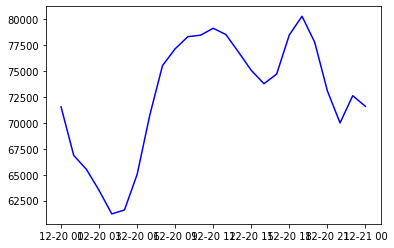

In [184]:
plot_load(Yconso, 2016, 12, 20,1)

<font color='green'>

* Afficher un jour ouvré d’hiver, un jour ouvré d’été, commenter.

</font>

## Afficher une semaine arbitraire de consommation

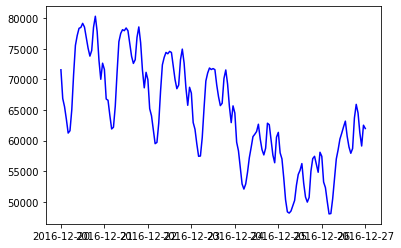

In [185]:
plot_load(Yconso, 2016, 12, 20, delta_days=7)

<font color='green'>

* Commenter.

</font>

## Observation des profils de la consommation pour les mois d'hiver et les mois d'été
Toujours dans le but d'appréhender nos données, on va regarder les profils moyens pour les mois d'été et pour ceux d'hiver. On va également observer le min et le max pour avoir une idée de la variabilité du signal.

In [186]:
# Par commodité, on isole le mois pour après attraper les mois d'hiver et d'été
Xinput['month'] = Xinput['ds'].dt.month

# On isole aussi les heures
Xinput['hour'] = Xinput['ds'].dt.hour

# On sépare les jours de la semaine 
# La fonction datetime.weekday() renvoie 0 => Lundi, 1 => Mardi, ..., 5 => Samedi, 6 => Dimanche
Xinput['weekday'] = Xinput['ds'].dt.weekday 

In [187]:
Xinput.head(5)

,ds,X002Th_real_24h_avant,X005Th_real_24h_avant,X015Th_real_24h_avant,X027Th_real_24h_avant,X070Th_real_24h_avant,X110Th_real_24h_avant,X120Th_real_24h_avant,X130Th_real_24h_avant,X145Th_real_24h_avant,...,X650Th_prev,X675Th_prev,X690Th_prev,X747Th_prev,holiday,FranceTh_real_24h_avant,FranceTh_prev,month,hour,weekday
24,2012-12-29 00:00:00+00:00,9.50,11.90,10.50,11.70,10.10,12.40,13.00,11.80,9.90,...,11.60,11.80,11.10,12.00,NaN,9.339850,10.734500,12,0,5
25,2012-12-29 01:00:00+00:00,9.50,11.90,10.50,11.69,10.11,12.40,13.01,11.80,9.90,...,11.60,11.80,11.10,12.01,NaN,9.339580,10.735110,12,1,5
26,2012-12-29 02:00:00+00:00,9.50,11.89,10.51,11.68,10.12,12.39,13.02,11.81,9.89,...,11.61,11.81,11.10,12.02,NaN,9.337955,10.733485,12,2,5
27,2012-12-29 03:00:00+00:00,9.51,11.88,10.53,11.66,10.14,12.39,13.05,11.82,9.89,...,11.61,11.81,11.11,12.04,NaN,9.338565,10.733050,12,3,5
28,2012-12-29 04:00:00+00:00,9.51,11.86,10.54,11.63,10.17,12.38,13.08,11.83,9.88,...,11.62,11.82,11.11,12.06,NaN,9.337475,10.731165,12,4,5


In [188]:
# On aggrège les mois d'hiver ensemble
XY_df = pd.merge(Yconso, Xinput, on = 'ds')
groupedHiver = XY_df[(XY_df.month == 12) | 
                                     (XY_df.month == 1) | 
                                     (XY_df.month == 2)].groupby(['weekday', 'hour'], as_index=True)

# Idem pour les mois d'été
groupedEte = XY_df[(XY_df.month == 6) | 
                                   (XY_df.month == 7) | 
                                   (XY_df.month == 8)].groupby(['weekday', 'hour'], as_index=True)

statsHiver = groupedHiver['y'].aggregate([np.mean, np.min, np.max])
statsEte = groupedEte['y'].aggregate([np.mean, np.min, np.max])
display(statsHiver)

mean   amin   amax
weekday hour                            
0       0     65783.655738  55360  78404
        1     61865.557377  51056  75157
        2     61269.918033  49822  74962
        3     59220.655738  47461  73056
        4     57217.803279  45691  71163
...                    ...    ...    ...
6       19    68453.016667  57047  81711
        20    68466.100000  57139  82094
        21    66030.750000  55295  79228
        22    63457.750000  53033  76323
        23    66646.583333  56162  79646

[168 rows x 3 columns]

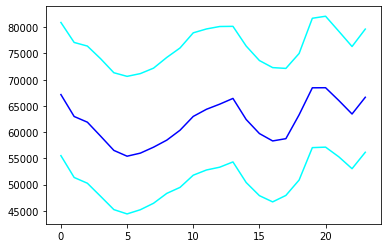

In [189]:
# On affiche des infos sur le profil pour les jours de la semaine
# 0 => Lundi, 1 => Mardi, ..., 5 => Samedi, 6 => Dimanche
jour = statsHiver.loc[6]  

plt.plot(jour['amin'], color='cyan')
plt.plot(jour['mean'], color='blue')
plt.plot(jour['amax'], color='cyan')
plt.show()

## Lien avec la consommation passée
A l'aide de la fonction shift, pour un point horaire cible on regarde  :
- la consommation de l'heure précédente, 
- du jour précédent, 
- de la semaine précédente.


In [190]:
Xinput['lag1H'] = Yconso['y'].shift(1)
Xinput['lag1D'] = Yconso['y'].shift(24)
Xinput['lag1W'] = Yconso['y'].shift(24*7)

Xinput.head(24 * 7 + 1)

,ds,X002Th_real_24h_avant,X005Th_real_24h_avant,X015Th_real_24h_avant,X027Th_real_24h_avant,X070Th_real_24h_avant,X110Th_real_24h_avant,X120Th_real_24h_avant,X130Th_real_24h_avant,X145Th_real_24h_avant,...,X747Th_prev,holiday,FranceTh_real_24h_avant,FranceTh_prev,month,hour,weekday,lag1H,lag1D,lag1W
24,2012-12-29 00:00:00+00:00,9.50,11.90,10.50,11.70,10.10,12.40,13.00,11.80,9.90,...,12.00,NaN,9.339850,10.734500,12,0,5,NaN,NaN,NaN
25,2012-12-29 01:00:00+00:00,9.50,11.90,10.50,11.69,10.11,12.40,13.01,11.80,9.90,...,12.01,NaN,9.339580,10.735110,12,1,5,59182.0,NaN,NaN
26,2012-12-29 02:00:00+00:00,9.50,11.89,10.51,11.68,10.12,12.39,13.02,11.81,9.89,...,12.02,NaN,9.337955,10.733485,12,2,5,54584.0,NaN,NaN
27,2012-12-29 03:00:00+00:00,9.51,11.88,10.53,11.66,10.14,12.39,13.05,11.82,9.89,...,12.04,NaN,9.338565,10.733050,12,3,5,53957.0,NaN,NaN
28,2012-12-29 04:00:00+00:00,9.51,11.86,10.54,11.63,10.17,12.38,13.08,11.83,9.88,...,12.06,NaN,9.337475,10.731165,12,4,5,51338.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
188,2013-01-04 20:00:00+00:00,9.10,9.70,10.00,10.00,9.70,9.90,9.90,10.10,9.40,...,13.40,NaN,7.653025,8.211950,1,20,4,72462.0,71765.0,NaN
189,2013-01-04 21:00:00+00:00,9.20,9.60,9.90,9.90,9.70,10.00,9.80,9.90,9.20,...,13.40,NaN,7.472100,7.876650,1,21,4,69629.0,67414.0,NaN
190,2013-01-04 22:00:00+00:00,9.30,9.60,9.80,10.00,9.80,9.90,9.60,10.00,9.00,...,13.50,NaN,7.196725,7.675100,1,22,4,65632.0,63613.0,NaN
191,2013-01-04 23:00:00+00:00,9.40,9.60,9.80,9.80,9.60,9.80,9.40,9.90,8.90,...,13.80,NaN,7.061050,7.264600,1,23,4,62355.0,66334.0,NaN


On trace maintenant les nuages de points afin de voir s'il y a corrélation ou non :

In [191]:
def plot_scatter_load(var_x):
    plt.scatter(Xinput[var_x],Yconso['y'])
    plt.title(var_x)
    plt.show()

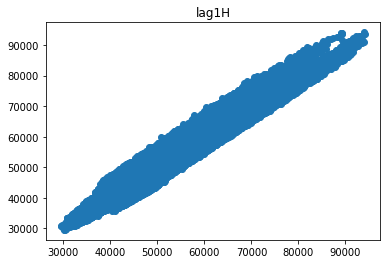

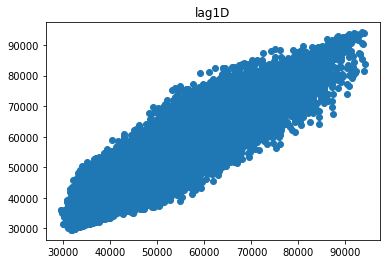

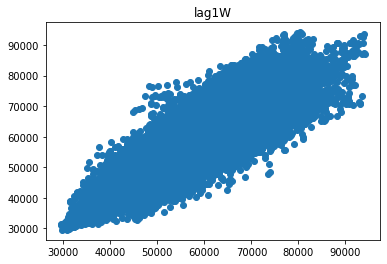

In [192]:
plot_scatter_load('lag1H')
plot_scatter_load('lag1D')
plot_scatter_load('lag1W')

<font color='green'>
    
* Quelle(s) variable(s) vous semble(nt) pertinentes pour construire un modèle de prévision à J+1?

* Lesquelles pouvez-vous raisonnablement utiliser dans un processus opérationnel?

</font>

## Visualiser la consommation en fonction de la température 

On voudrait savoir si la consommation nationale peut s'expliquer en regardant simplement la température moyenne sur la France. Pour cela, on peut aussi tracer un nuage de points.

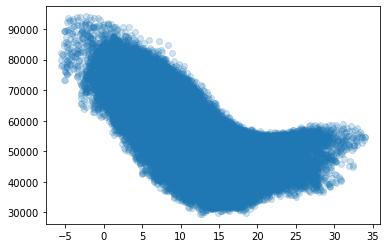

In [193]:
plt.scatter(Xinput['FranceTh_prev'], Yconso['y'], alpha=0.2)
plt.show()

<font color='green'>
    
* Que pensez-vous de ce nuage ? 
* Quelles autres variables explicatives proposeriez-vous? De quels types sont-elles?

<font color='green'>

# Ajout de variables

On récupère le jour de l'année grâce à la fonction *dayofyear*

In [194]:
time = pd.to_datetime(Xinput['ds'], yearfirst=True,utc=True)
Xinput['posan']= time.dt.dayofyear

In [195]:
Xinput.columns


Index(['ds', 'X002Th_real_24h_avant', 'X005Th_real_24h_avant',
       'X015Th_real_24h_avant', 'X027Th_real_24h_avant',
       'X070Th_real_24h_avant', 'X110Th_real_24h_avant',
       'X120Th_real_24h_avant', 'X130Th_real_24h_avant',
       'X145Th_real_24h_avant', 'X149Th_real_24h_avant',
       'X156Th_real_24h_avant', 'X168Th_real_24h_avant',
       'X180Th_real_24h_avant', 'X190Th_real_24h_avant',
       'X222Th_real_24h_avant', 'X240Th_real_24h_avant',
       'X255Th_real_24h_avant', 'X260Th_real_24h_avant',
       'X280Th_real_24h_avant', 'X299Th_real_24h_avant',
       'X434Th_real_24h_avant', 'X460Th_real_24h_avant',
       'X481Th_real_24h_avant', 'X497Th_real_24h_avant',
       'X510Th_real_24h_avant', 'X579Th_real_24h_avant',
       'X588Th_real_24h_avant', 'X621Th_real_24h_avant',
       'X630Th_real_24h_avant', 'X643Th_real_24h_avant',
       'X645Th_real_24h_avant', 'X650Th_real_24h_avant',
       'X675Th_real_24h_avant', 'X690Th_real_24h_avant',
       'X747Th_real_24h_a

In [196]:
Xinput.to_csv("data/X2input.csv", index = False)